## Random Forest Classifier

### Importing necessary libraries

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, validation_curve, cross_val_score, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

### Data Loading
Loads the IMDB dataset using TensorFlow's Keras module, creating training, validation and testing sets.

In [16]:
from tensorflow.keras.datasets import imdb

m = 3000 # Number of words in the vocabulary 
n = 20 # most frequent words to skip

# Load the IMDB dataset
(train_data, train_labels), (test_data, test_labels)= imdb.load_data(num_words=m, skip_top=n)
print("Number of training samples =", len(train_data))
print("Number of test samples =", len(test_data))

Number of training samples = 25000
Number of test samples = 25000


### Data Visualization


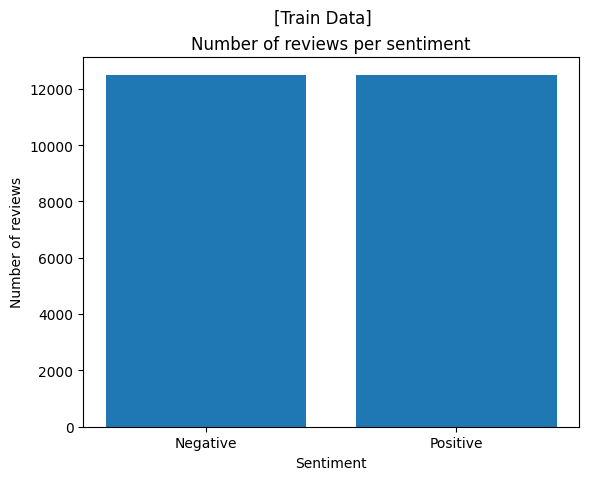

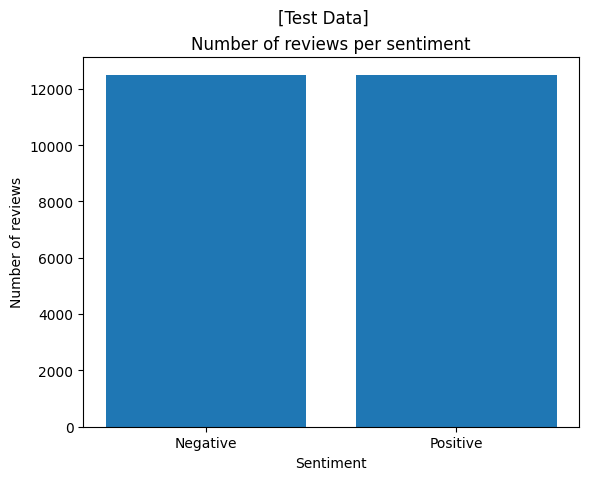

In [18]:
def plot_barplot(df, label=''):
    class_counts = df['Sentiment'].value_counts()
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of reviews')
    plt.title('Number of reviews per sentiment')
    plt.suptitle(f'[{label}]')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.show()
    
df_train = pd.DataFrame({'Reviews':train_data, 'Sentiment': train_labels})
plot_barplot(df_train, 'Train Data')

df_test = pd.DataFrame({'Reviews':test_data, 'Sentiment': test_labels})
plot_barplot(df_test, 'Test Data')

### Convert the IMDB integer sequences to text

In [19]:
# Load the word index
word_index = imdb.get_word_index()

# The first indices are reserved
index_to_word = dict((idx + 3, word) for (word, idx) in word_index.items())
index_to_word[0] = '<PAD>' # Padding (not used)
index_to_word[1] = '<START>' # Start of the review (not used)
index_to_word[2] = '<UNK>' # Unknown word (word not in the vocabulary)

decoded_train_data = [' '.join([index_to_word.get(idx) for idx in review]) for review in train_data]
decoded_test_data = [' '.join([index_to_word.get(idx) for idx in review]) for review in test_data]

In [20]:
print(decoded_train_data[0])
print(decoded_test_data[0])

<UNK> <UNK> film <UNK> just brilliant casting location scenery story direction <UNK> really <UNK> <UNK> part they played <UNK> you could just imagine being there robert <UNK> <UNK> an amazing actor <UNK> now <UNK> same being director <UNK> father came from <UNK> same <UNK> island <UNK> myself so <UNK> loved <UNK> fact there <UNK> <UNK> real connection <UNK> <UNK> film <UNK> witty <UNK> throughout <UNK> film were great <UNK> <UNK> just brilliant so much <UNK> <UNK> bought <UNK> film <UNK> soon <UNK> <UNK> <UNK> released <UNK> <UNK> <UNK> would recommend <UNK> <UNK> everyone <UNK> watch <UNK> <UNK> fly <UNK> <UNK> amazing really <UNK> at <UNK> end <UNK> <UNK> so sad <UNK> you know what they say if you cry at <UNK> film <UNK> must have been good <UNK> <UNK> definitely <UNK> also <UNK> <UNK> <UNK> two little <UNK> <UNK> played <UNK> <UNK> <UNK> <UNK> <UNK> paul they were just brilliant children are often left out <UNK> <UNK> <UNK> list <UNK> think because <UNK> stars <UNK> play them all gr

In [21]:
# Free up memory
del train_data, test_data

### Vectorize the datasets

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

# Combine the two sets of stop words
stop_words = set(nltk_stop_words.words('english')).union(sklearn_stop_words)
# Convert the set to a list
stop_words = list(stop_words)
print(stop_words)

['beyond', 'yet', 'many', 'there', 'across', 'well', 'too', 'although', 'much', 'forty', 'myself', "it's", 'whereafter', 'become', 'just', "she's", 'back', 'hadn', 'seem', 'except', "shouldn't", 'weren', 'once', 'whoever', 'wouldn', 'at', 'was', 'detail', 'all', "you're", 'did', 'll', 'eleven', 'amoungst', 've', "you'd", 'serious', 'alone', "mustn't", 'per', 'shouldn', 'would', 'after', "wouldn't", 'keep', 'though', 'only', 'about', 'before', 'cannot', 'front', 'from', 'even', 'has', 'moreover', 'these', 'fire', 'towards', 'its', "hasn't", 'their', 'un', 'are', 'describe', 'whatever', 'take', 'two', 'itself', "wasn't", 'anywhere', 'theirs', 'thereafter', 'during', 'it', 'made', 'third', 'into', 'o', 'those', "couldn't", 'sometime', 'ie', 'toward', 'everywhere', 'inc', 'he', 'they', 'hers', 'latterly', 'hasnt', "shan't", 'mine', 'whom', "you've", 'will', 'mostly', 'co', 'often', 'within', "aren't", 'something', 'when', 'four', 'each', 'aren', 'ltd', "won't", 'around', 'former', 'bottom'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# Create the CountVectorizer object
vectorizer = CountVectorizer(binary=True)
# Fit the vectorizer to the train data and transform it into vectors
X_train_vectorized = (vectorizer.fit_transform(decoded_train_data))
# Transform the test data into vectors
X_test_vectorized = (vectorizer.transform(decoded_test_data))

In [24]:
# Free up memory
del decoded_train_data, decoded_test_data

In [25]:
def check_numeric_features(X1,X2):
    """
    Check if all features in the dataset are numeric.

    Parameters:
    X1 : array-like, The input data to check.
    X2 : array-like, The input data to check.

    Returns:
    bool: True if all features are numeric, False otherwise.
    """
    if np.issubdtype(X1.dtype, np.number) and np.issubdtype(X2.dtype, np.number):
        print("All features are numeric.")
    else:
        print("Not all features are numeric.")
        
check_numeric_features(X_train_vectorized, X_test_vectorized)

All features are numeric.


In [26]:
# Convert the sparse matrix to a dense matrix and the labels to numpy arrays
X_train_vectorized = X_train_vectorized.toarray()
y_train = np.asarray(train_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42) # 80% training and 20% validation
X_test = X_test_vectorized.toarray()
y_test = np.asarray(test_labels)

In [27]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape) 

(20000, 2916) (20000,) (5000, 2916) (5000,) (25000, 2916) (25000,)


### Evaluation Functions

In [3]:
def evaluate_estimator(estimator,x_train, y_train, x_val, y_val,splits=5):
    train_accuracies, train_recalls, train_precisions, train_f1 = [], [], [], []
    test_accuracies, test_recalls, test_precisions, test_f1 = [], [], [], []
    split_size = len(x_train) // splits

    for i in range(1, splits + 1):
        x_train_split, y_train_split = x_train[:i * split_size], y_train[:i * split_size]
        estimator.fit(x_train_split, y_train_split)

        train_pred, test_pred = estimator.predict(x_train_split), estimator.predict(x_val)

        train_accuracies.append(accuracy_score(y_train_split, train_pred))
        test_accuracies.append(accuracy_score(y_val, test_pred))

        train_precisions.append(precision_score(y_train_split, train_pred))
        test_recalls.append(precision_score(y_val, test_pred))

        train_recalls.append(recall_score(y_train_split, train_pred))
        test_precisions.append(recall_score(y_val, test_pred))

        train_f1.append(f1_score(y_train_split, train_pred))
        test_f1.append(f1_score(y_val, test_pred))
    
    train_final_cm = confusion_matrix(y_train, train_pred)
    test_final_cm = confusion_matrix(y_val, test_pred)

    return {'estimator': estimator.__class__.__name__,
            'num_features': x_train.shape[1],
            'split_size': split_size,
            'splits': splits,
            'train_predictions': train_pred,
            'test_predictions': test_pred,
            'train_accuracy': train_accuracies,
            'test_accuracy': test_accuracies,
            'train_error': [1 - acc for acc in train_accuracies],
            'test_error': [1 - acc for acc in test_accuracies],
            'train_precision': train_precisions,
            'test_precision': test_precisions,
            'train_recall': train_recalls,
            'test_recall': test_recalls,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'train_final_cm': train_final_cm,
            'test_final_cm': test_final_cm}  

In [4]:
def print_confusion_matrix(cm , label):    
    print('Confusion Matrix:')
    print(f'True Negatives: {cm[0][0]}')
    print(f'False Positives: {cm[0][1]}')
    print(f'False Negatives: {cm[1][0]}')
    print(f'True Positives: {cm[1][1]}')

In [5]:
def print_classification_report(evaluation_results, y_true, label='Test'):
    # Set the metric to use
    if label == 'Test':
        dataset = 'test'
    else:
        dataset = 'train'
        
    # Get the predictions on the set  
    y_pred = evaluation_results[f'{dataset}_predictions']
    print("Used ", evaluation_results['num_features'], " Features.")
    # Generate and print the classification report
    print(f'Classification Report for {label} Data:')
    print(classification_report(y_true, y_pred, digits=4))
    
    # Access pre-calculated metrics
    accuracy = evaluation_results[f'{dataset}_accuracy'][-1]  # Last value in the accumulated lists
    error = evaluation_results[f'{dataset}_error'][-1]
    precision = evaluation_results[f'{dataset}_precision'][-1]
    recall = evaluation_results[f'{dataset}_recall'][-1]
    f1 = evaluation_results[f'{dataset}_f1'][-1]
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Error: {error:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print()
    # Display the confusion matrix
    cm = evaluation_results[f'{dataset}_final_cm']
    print_confusion_matrix(cm, label)


In [7]:
def format_Hyperparameters(hyperparameters, label):
    """
    Formats the hyperparameters for display.

    Arguments:
      hyperparameters: A dictionary containing the hyperparameters.
      label: The label of the estimator.
    Returns:
      A string containing the formatted hyperparameters.
    """
    if label == 'Sklearn':
        hyperparameters_to_retrieve = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
        selected_hyperparameters = {param: hyperparameters[param] for param in hyperparameters_to_retrieve}
        # Format the selected hyperparameters for display
        hyperparameters_text = " ".join([f"{key}: {value}," for key, value in selected_hyperparameters.items()])
    else :
        hyperparameters_text = " ".join([f"{key}: {value}," for key, value in hyperparameters.items()])
    hyperparameters_text = hyperparameters_text[:-1]  # Remove the last comma    
    return hyperparameters_text

### Plotting Functions

In [8]:
from matplotlib.ticker import FuncFormatter
# Function to format the x-axis labels as integers
def format_fn(tick_val, tick_pos):
    if int(tick_val) >= 0:
        return int(tick_val)
    else:
        return ''
        
def plot_learning_curves(estimator, classification_data, label):
  """
  Visualize both normal and zoomed learning curves of accuracy, precision, recall, and F1 for training and testing sets.

  Arguments:
    classification_data: The dictionary containing the train/test data.
  """
  
  # Retrieve the hyperparameters from the estimator
  hyperparameters_text = format_Hyperparameters(estimator.get_params(), label)
          
  num_splits = classification_data['splits']
  split_size = classification_data['split_size']

  x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

  metrics = ['Accuracy', 'Error', 'Precision', 'Recall', 'F1']

  for metric in metrics:
    # Create a new figure for each metric
    plt.figure(figsize=(14, 5))
    train_values = classification_data[f'train_{metric.lower()}']
    test_values = classification_data[f'test_{metric.lower()}']
        
    # Plot normal learning curves
    plt.subplot(1, 2, 1)
    plt.plot(x_values, train_values, label='Train')
    plt.plot(x_values, test_values, label='Test')
    plt.title(f'{metric}')
    plt.xticks(x_values)
    plt.ylim(0.0 - 0.1, 1.0 + 0.1)
    plt.legend(loc='lower left')
    ax = plt.gca()  # Get the current axis
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    # Plot zoomed learning curves
    plt.subplot(1, 2, 2)
    plt.plot(x_values, train_values, label='Train')
    plt.plot(x_values, test_values, label='Test')
    plt.title(f'{metric} (Zoomed In)')
    plt.xticks(x_values)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    # Calculate y-axis limits based on the range of y-values for each metric
    y_min = min(min(train_values), min(test_values))
    y_max = max(max(train_values), max(test_values))
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
        
    plt.suptitle(f"Learning Curve for {classification_data['estimator']} - {metric}", fontsize=16)
    # Display the other hyperparameters on the plot
    plt.gcf().text(0.5, 0.92, hyperparameters_text, fontsize=10, ha='center', va='top')
    plt.gcf().supxlabel('Training Examples', ha='center', fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [9]:
def classification_cm_heatmap(estimator, cm, title, label='Sklearn'):
    """
    Creates a heatmap of the confusion matrix.

    Arguments:
      cm: The confusion matrix to be plotted.
      title: The title of the plot.
    Returns:
      A heatmap of the confusion matrix.
    """
    # Retrieve the formatted hyperparameters from the estimator
    hyperparameters_text = format_Hyperparameters(estimator.get_params(), label)
  
    cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative', 'Predicted Positive'],
                          index=['Actual Negative', 'Actual Positive'])
    
    plt.figure(figsize=(8, 6))
    ax = plt.axes()
    ax.set_title(f'Confusion Matrix Heatmap for {title}')
    plt.gcf().suptitle(hyperparameters_text, ha='center', fontsize=10)
    
    return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

In [10]:
def plot_ROC_curve(estimator, X_test, y_test, label='Sklearn'):
    """
    Plot the ROC curve for a binary classification model.

    Parameters:
    - y_true: True labels (ground truth).
    - y_scores: Predicted scores or probabilities for the positive class.
    - label (optional): Label for the classifier (default is 'Classifier').
    """
    # Get the predicted probabilities on the test set
    y_test_pred_proba = estimator.predict_proba(X_test)[:, 1]

    # Retrieve the formatted hyperparameters from the estimator
    hyperparameters_text = format_Hyperparameters(estimator.get_params(), label)

    # Plotting the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc = roc_auc_score(y_test, y_test_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', linewidth=2, label=f' AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='black')  # dashed diagonal
    plt.title('ROC Curve for ' + label + ' Random Forest')
    # Display the other hyperparameters on the plot
    plt.gcf().suptitle(hyperparameters_text, ha='center', fontsize=10)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.show()

In [11]:
def showValidationCurve(param_range, param_name, train_scores, val_scores, metric_name, hyperparameters_text, label):
    """
    Plot the validation curve for a given hyperparameter.
    
    Parameters:
    param_range (list): The range of values for the hyperparameter.
    param_name (str): The name of the hyperparameter.
    train_scores (list): The training scores for each value of the hyperparameter.
    val_scores (list): The validation scores for each value of the hyperparameter.
    metric_name (str): The name of the evaluation metric.
    hyperparameters_text (str): The text describing the other hyperparameters.
    label (str): The label for the random forest model.

    Returns:
    None
    """
    # Plotting the validation curve for each metric
    plt.plot(param_range, train_scores, label='Training '+ metric_name, color='green')
    plt.plot(param_range, val_scores, label='Validation '+ metric_name, color='red')
    plt.title(f'Validation Curve with {label} Random Forest ({param_name})')
    plt.xlabel(param_name)
    plt.ylabel(metric_name)
    # Display the other hyperparameters on the plot
    plt.gcf().suptitle(hyperparameters_text, ha='center', fontsize=10)
    plt.legend(loc='best')
    plt.show()

In [13]:
def plot_metrics_table(classifier_data):
  """
  Creates and displays a table of the train/val accuracies, error, precision, recall and
  and F1 scores for each split. 

  Arguments:
    evaluate_metrics: The dictionary containing the train/test data metrics.
  """
  num_splits = classifier_data['splits']
  split_size = classifier_data['split_size']
  
  metrics_data = {}
    
  for metric in ['Accuracy', 'Error', 'Precision', 'Recall', 'F1']:
    for data_type in ['Train', 'Test']:
      metrics_data[f'{metric} {data_type}'] = np.round(classifier_data[f'{data_type.lower()}_{metric.lower()}'], 4)

  df = pd.DataFrame(metrics_data, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

  display(df)

In [14]:
def plot_metrics_table_differences(classifier1_data, classifier2_data):
  """
  Creates a table of the differences in train/val accuracy, error, precision, recall,
  and F1 scores between two classifiers for each split.

  Arguments:
    classifier1_data: Dictionary containing train/test data for classifier 1.
    classifier2_data: Dictionary containing train/test data for classifier 2.
  Returns:
    A DataFrame table of the differences in metrics.
  """

  split_size = classifier1_data['split_size']
  num_splits = classifier1_data['splits']
  
  metrics_data = {}

  for metric in ['Accuracy', 'Error', 'Precision', 'Recall', 'F1']:
    for data_type in ['Train', 'Test']:
        metrics_data[f'{metric} {data_type}'] = np.round(classifier1_data[f'{data_type.lower()}_{metric.lower()}'], 2) - np.round(classifier2_data[f'{data_type.lower()}_{metric.lower()}'], 2)

  df = pd.DataFrame(metrics_data, index=list(range(split_size, split_size * (num_splits + 1), split_size)))

  display(df)

In [15]:
def plot_classifier_differences(estimator, classifier1_data, classifier2_data):
  """
  Visualize the differences between two classifiers and their learning curves for accuracy, precision, recall, and F1.

  Arguments:
    classifier1_data: Dictionary containing train/test data for classifier 1.
    classifier2_data: Dictionary containing train/test data for classifier 2.
  """

  num_splits = classifier1_data['splits']
  split_size = classifier1_data['split_size']
  x_values = list(range(split_size, split_size * (num_splits + 1), split_size))

  for metric in ['Accuracy', 'Error', 'Precision', 'Recall', 'F1']:
    plt.figure(figsize=(8, 4))
        
    # Plot normal learning curves for both classifiers
    plt.subplot(1, 2, 1)
    plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
    plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
    plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
    plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
    plt.title(metric)
    plt.ylim(0.0 - 0.1, 1.0 + 0.1)
    plt.legend(loc='best')

    # Plot zoomed-in learning curves for both classifiers
    plt.subplot(1, 2, 2)
    plt.plot(x_values, classifier1_data[f'train_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Train)")
    plt.plot(x_values, classifier1_data[f'test_{metric.lower()}'], label=f"{classifier1_data['estimator']} (Test)")
    plt.plot(x_values, classifier2_data[f'train_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Train)")
    plt.plot(x_values, classifier2_data[f'test_{metric.lower()}'], label=f"{classifier2_data['estimator']} (Test)")
    plt.title(f'{metric} (Zoomed In)')

    # Calculate y-axis limits based on the range of y-values for each metric
    y_min_cl1 = min(min(classifier1_data[f'train_{metric.lower()}']), min(classifier1_data[f'test_{metric.lower()}']))
    y_max_cl1 = max(max(classifier1_data[f'train_{metric.lower()}']), max(classifier1_data[f'test_{metric.lower()}']))
    y_min_cl2 = min(min(classifier2_data[f'train_{metric.lower()}']), min(classifier2_data[f'test_{metric.lower()}']))
    y_max_cl2 = max(max(classifier2_data[f'train_{metric.lower()}']), max(classifier2_data[f'test_{metric.lower()}']))
    y_min = min(y_min_cl1, y_min_cl2)
    y_max = max(y_max_cl1, y_max_cl2)
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    # Retrieve the formatted hyperparameters from the estimator
    hyperparameters_text = format_Hyperparameters(estimator.get_params(), '')
    
    plt.suptitle(f"{metric} Differences {classifier1_data['estimator']} - {classifier2_data['estimator']}", fontsize=16)
    plt.gcf().suptitle(hyperparameters_text, ha='center', fontsize=10)
    plt.gcf().supxlabel('Training Examples', ha='center', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()                      

### Random Forest Classifier Implementation

In [2]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.tree import DecisionTreeClassifier


"""
Returns a bootstrapped sample of the data (with replacement).
"""
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idx = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[idx], y[idx]
    
"""
Implementation of a Random Forest classifier
"""
class RandomForest:

    def __init__(self, n_trees=100, min_samples_split=2, min_samples_leaf=1, max_depth=20, max_features=10):
        self.n_trees = n_trees
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.n_features = None
        
    """
    Trains a tree using the ID3 algorithm and a bootstrapped sample of the data.
    """
    def train_tree(self, X, y):
        X_sample, y_sample = bootstrap_sample(X, y)
        tree = DecisionTreeClassifier(criterion='entropy', max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
        tree.fit(X_sample, y_sample)
        return tree
    
    """
    Fit the Random Forest model to the training data.
    """
    def fit(self, X, y):
        self.n_features = X.shape[1]  # Store the number of features
        with ThreadPoolExecutor() as executor:
            self.trees = list(executor.map(lambda _: self.train_tree(X, y), range(self.n_trees)))
    
    """
    Predict the class for each sample in X using majority voting.
    """
    def predict(self, X):
        with ThreadPoolExecutor() as executor:
            predictions = np.array(list(executor.map(lambda tree: tree.predict(X), self.trees)))
            majority_votes = np.apply_along_axis(self.break_ties, axis=0, arr=predictions)
        return majority_votes
        
    """
    Utility function to break ties in majority voting.
    """
    def break_ties(self, votes):
        vote_count = Counter(votes)
        top_two = vote_count.most_common(2)
        if len(top_two) > 1 and top_two[0][1] == top_two[1][1]:
            return np.random.choice([top_two[0][0], top_two[1][0]])
        return top_two[0][0]
    
    """
    Predict the class probabilities for each sample in X using majority voting. (To be used with roc_curve)
    """
    def predict_proba(self, X):
        predictions_proba = np.array([tree.predict_proba(X) for tree in self.trees])
        majority_votes_proba = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions_proba)
        return majority_votes_proba
        
    """
    Returns the parameters of the classifier.
    """
    def get_params(self, deep=True):
        return {"n_trees": self.n_trees, "min_samples_split": self.min_samples_split, 
            "max_depth": self.max_depth, "max_features": self.max_features, "min_samples_leaf": self.min_samples_leaf}
    
    """
    Sets the parameters of the classifier.
    """
    def set_params(self, **parameters):
        # Set parameters for the model
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        # Return the updated instance
        return self

### Fine Tuning the hyperparameters of our model

In [28]:
# Number of trees in the forest
max_trees = 350
# Maximum depth of each tree
max_depth = 70
# Minimum number of samples required to split an internal node
minimum_samples_split =  10
# Minimum number of samples required to be at a leaf node
minimum_samples_leaf = 6
# Number of features to consider when looking for the best split
max_features = 20

Initialize the custom classifier with hard-coded hyperparameter values.

In [29]:
random_forest = RandomForest(n_trees=max_trees, min_samples_split=minimum_samples_split, min_samples_leaf=minimum_samples_leaf, max_depth=max_depth, max_features=max_features)

In [12]:
def plot_validation_curve(estimator_params, X_train, y_train, X_val, y_val, param_name, param_range, metrics, label='Sklearn'):
    """
    Plots the validation curves for a given estimator.

    Parameters:
    - estimator_params (dict): Dictionary of estimator parameters.
    - X_train (array-like): Training data.
    - y_train (array-like): Target values for the training data.
    - X_val (array-like): Validation data.
    - y_val (array-like): Target values for the validation data.
    - param_name (str): Name of the parameter to vary.
    - param_range (array-like): Values of the parameter to try.
    - metrics (list): List of evaluation metrics to calculate.
    - label (str): Label for the estimator. Default is 'Sklearn'.

    Returns:
    None
    """
    
    train_scores_acc, val_scores_acc = [], []
    train_scores_err, val_scores_err = [], []
    train_scores_prec, val_scores_prec = [], []
    train_scores_rec, val_scores_rec = [], []
    train_scores_f1, val_scores_f1 = [], []
    
    metric_names = []
    
    # Instantiate the estimator
    if label == 'Sklearn' :
        estimator = RandomForestClassifier()
    else :
        estimator = RandomForest()
    estimator.set_params(**estimator_params)
    
    for value in param_range:
    
        # Set the parameter value
        estimator.set_params(**{param_name: value})

        # Fit the model on the training set
        estimator.fit(X_train, y_train)

        # Predict on both the training and the validation set
        y_train_pred = estimator.predict(X_train)
        y_val_pred = estimator.predict(X_val)
        
        for metric in metrics:
        
            if metric == 'accuracy':
                metric_names.append('Accuracy Score')
                # Calculate the accuracy scores and store them in lists
                train_acc = accuracy_score(y_train, y_train_pred)
                val_acc = accuracy_score(y_val, y_val_pred)
                
                train_scores_acc.append(train_acc)
                val_scores_acc.append(val_acc)
                
            elif metric == 'error':
                metric_names.append('Error Score')
                # Calculate the error scores and store them in lists
                train_err = 1 - accuracy_score(y_train, y_train_pred)
                val_err = 1 - accuracy_score(y_val, y_val_pred)
                
                train_scores_err.append(train_err)
                val_scores_err.append(val_err)
            
            elif metric == 'precision':
                metric_names.append('Precision Score')
                # Calculate the precision scores and store them in lists
                train_prec = precision_score(y_train, y_train_pred)
                val_prec = precision_score(y_val, y_val_pred)
                
                train_scores_prec.append(train_prec)
                val_scores_prec.append(val_prec)
            
            elif metric == 'recall':
                metric_names.append('Recall Score')
                # Calculate the recall scores and store them in lists
                train_rec = recall_score(y_train, y_train_pred)
                val_rec = recall_score(y_val, y_val_pred)
                
                train_scores_rec.append(train_rec)
                val_scores_rec.append(val_rec)
                
            else: # metric == 'f1'
                # Calculate the F1 scores and store them in lists
                metric_names.append('F1 Score')
                train_f1 = f1_score(y_train, y_train_pred)
                val_f1 = f1_score(y_val, y_val_pred)
        
                train_scores_f1.append(train_f1)
                val_scores_f1.append(val_f1)
        
    # Retrieve the formatted hyperparameters from the estimator
    hyperparameters_text = format_Hyperparameters(estimator_params, label)
    
    # Plot the validation curves for each metric
    showValidationCurve(param_range, param_name, train_scores_acc, val_scores_acc, metric_names[0], hyperparameters_text, label) # Accuracy
    showValidationCurve(param_range, param_name, train_scores_err, val_scores_err, metric_names[1], hyperparameters_text, label) # Error
    showValidationCurve(param_range, param_name, train_scores_prec, val_scores_prec, metric_names[2], hyperparameters_text, label) # Precision
    showValidationCurve(param_range, param_name, train_scores_rec, val_scores_rec, metric_names[-2], hyperparameters_text, label) # Recall
    showValidationCurve(param_range, param_name, train_scores_f1, val_scores_f1, metric_names[-1], hyperparameters_text, label) # F1

Run randomized search on different parameter distributions and keep the set of hyperparameters that provides the highest accuracy on the validation set.

In [6]:
from sklearn.model_selection import PredefinedSplit

def randomized_search(X_train, y_train, X_val, y_val, param_distributions, scoring=['accuracy', 'f1'], n_iter=20, cv=5, n_jobs=6, label='My'):
    """
    Perform randomized search for hyperparameter tuning using RandomizedSearchCV.

    Parameters:
    - X_train (array-like): The training input samples.
    - y_train (array-like): The target values.
    - param_distributions (dict): Dictionary with parameters names (string) as keys and distributions or lists of parameters to try as values.
    - scoring (str, default='accuracy'): Scoring metric to evaluate the predictions on the test set.
    - n_iter (int, default=20): Number of parameter settings that are sampled.
    - cv (int, default=5): Determines the cross-validation splitting strategy.
    - n_jobs (int, default=6): Number of jobs to run in parallel.
    - label (str, default='My'): Label to determine the type of estimator to create.

    Returns:
    - best_params (dict): Best parameters found during the search.
    - best_score (float): Best score achieved during the search.
    """
    # Create the estimator
    estimator = RandomForest() if label=='My' else RandomForestClassifier()
    
    X_train_val = np.concatenate((X_train, X_val), axis=0)
    y_train_val = np.concatenate((y_train, y_val), axis=0)
    
    # Generate a list where -1 indicates a training sample and 0 indicates a validation sample
    test_fold = [-1]*len(X_train) + [0]*len(X_val)  # -1 for train, 0 for validation
    
    # Create the PredefinedSplit
    ps = PredefinedSplit(test_fold)
    
    # Create the randomized search
    randomized_search = RandomizedSearchCV(estimator, param_distributions=param_distributions, scoring=scoring, refit='accuracy', n_iter=n_iter, cv=ps, n_jobs=n_jobs, verbose=1, random_state=42)
    # Fit the model
    randomized_search.fit(X_train_val, y_train_val)
    
    # Get the best parameters and the best score
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_ # Retrive the best mean cross-validated Accuracy score achieved during the search
    
    # Print the best parameters and the best score
    print("Best parameters:", best_params)
    print("Best Accuracy score:", best_score)
    
    return best_params, best_score
    

In [31]:
param_distributions_MY={
'n_trees': [100, 150, 200, 250, 300, 350, 400],
'max_depth': [10, 20, 30, 40, 50, 60, 70],
'min_samples_split': [6, 8, 12, 16, 20],
'min_samples_leaf': [2, 4, 6, 8, 10],
'max_features': [10, 20, 30, 40, 50]}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_MY, n_iter=10, n_jobs=6, label='My')

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best parameters: {'n_trees': 300, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 50, 'max_depth': 60}
Best Accuracy score: 0.8426


({'n_trees': 300,
  'min_samples_split': 8,
  'min_samples_leaf': 8,
  'max_features': 50,
  'max_depth': 60},
 0.8426)

In [29]:
param_distributions_MY={
'n_trees': [250, 300, 350, 400],
'max_depth': [40, 50, 60, 70, 80, 100],
'min_samples_split': [6, 8, 12, 16, 20, 24, 28, 32],
'min_samples_leaf': [2, 4, 6, 8, 10, 12, 16, 20, 26],
'max_features': [20, 30, 40, 50, 60, 70]
}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_MY, n_iter=20, n_jobs=6, label='My')

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters: {'n_trees': 350, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 30, 'max_depth': 80}
Best Accuracy score: 0.8472


({'n_trees': 350,
  'min_samples_split': 8,
  'min_samples_leaf': 6,
  'max_features': 30,
  'max_depth': 80},
 0.8472)

In [30]:
param_distributions_MY={
'n_trees': [300, 350, 400],
'max_depth': [40, 50, 60, 70, 80, 90, 100, 120],
'min_samples_split': [4, 6, 8, 12, 16, 20],
'min_samples_leaf': [2, 4, 6, 8, 10, 12],
'max_features': [20, 30, 40, 50, 60]
}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_MY, n_iter=20, n_jobs=6, label='My')

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters: {'n_trees': 300, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 40, 'max_depth': 90}
Best Accuracy score: 0.8474


({'n_trees': 300,
  'min_samples_split': 6,
  'min_samples_leaf': 2,
  'max_features': 40,
  'max_depth': 90},
 0.8474)

In [31]:
param_distributions_MY={
'n_trees': [350, 300, 350, 400, 450, 500],
'max_depth': [40, 50, 60, 70, 80, 90, 100, 120, 140],
'min_samples_split': [4, 6, 8, 12],
'min_samples_leaf': [2, 4, 6, 8],
'max_features': [20, 30, 40, 50, 60, 70]
}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_MY, n_iter=30, n_jobs=6, label='My')

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Best parameters: {'n_trees': 400, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 20, 'max_depth': 80}
Best Accuracy score: 0.8478


({'n_trees': 400,
  'min_samples_split': 8,
  'min_samples_leaf': 8,
  'max_features': 20,
  'max_depth': 80},
 0.8478)

In [32]:
param_distributions_MY={
'n_trees': [250, 300, 350, 400, 450, 500],
'max_depth': [40, 50, 60, 70, 80, 90, 100, 120],
'min_samples_split': [3, 4, 6, 8, 12, 16, 20, 22],
'min_samples_leaf': [2, 4, 6, 8, 10, 12, 16, 20],
'max_features': [5, 10, 20, 30, 40, 50, 60, 70, 80]
}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_MY, n_iter=50, n_jobs=-1, label='My')

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Best parameters: {'n_trees': 500, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 20, 'max_depth': 100}
Best Accuracy score: 0.8492


({'n_trees': 500,
  'min_samples_split': 8,
  'min_samples_leaf': 4,
  'max_features': 20,
  'max_depth': 100},
 0.8492)

### Evaluate the model

In [30]:
classification_data = evaluate_estimator(random_forest, X_train, y_train, X_test, y_test, splits=5)

In [31]:
print_classification_report(classification_data, y_train, label='Train')

Used  2916  Features.
Classification Report for Train Data:
              precision    recall  f1-score   support

           0     0.9530    0.9415    0.9472     10063
           1     0.9414    0.9530    0.9472      9937

    accuracy                         0.9472     20000
   macro avg     0.9472    0.9472    0.9472     20000
weighted avg     0.9473    0.9472    0.9472     20000

Accuracy: 0.9472
Error: 0.0528
Precision: 0.9414
Recall: 0.9530
F1-score: 0.9472

Confusion Matrix:
True Negatives: 9474
False Positives: 589
False Negatives: 467
True Positives: 9470


In [32]:
print_classification_report(classification_data, y_test, label='Test')

Used  2916  Features.
Classification Report for Test Data:
              precision    recall  f1-score   support

           0     0.8461    0.8482    0.8472     12500
           1     0.8479    0.8458    0.8468     12500

    accuracy                         0.8470     25000
   macro avg     0.8470    0.8470    0.8470     25000
weighted avg     0.8470    0.8470    0.8470     25000

Accuracy: 0.8470
Error: 0.1530
Precision: 0.8458
Recall: 0.8479
F1-score: 0.8468

Confusion Matrix:
True Negatives: 10603
False Positives: 1897
False Negatives: 1928
True Positives: 10572


In [33]:
plot_metrics_table(classification_data)

,Accuracy Train,Accuracy Test,Error Train,Error Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.9598,0.8367,0.0403,0.1633,0.9566,0.8207,0.9619,0.8478,0.9593,0.8340
8000,0.9546,0.8427,0.0454,0.1573,0.9503,0.8356,0.9583,0.8477,0.9543,0.8416
12000,0.9506,0.8452,0.0494,0.1548,0.9451,0.8423,0.9563,0.8471,0.9507,0.8447
16000,0.9497,0.8462,0.0503,0.1538,0.9451,0.8407,0.9541,0.8500,0.9496,0.8453
20000,0.9472,0.8470,0.0528,0.1530,0.9414,0.8458,0.9530,0.8479,0.9472,0.8468


### Plot the Learning Curves for my Random Forest

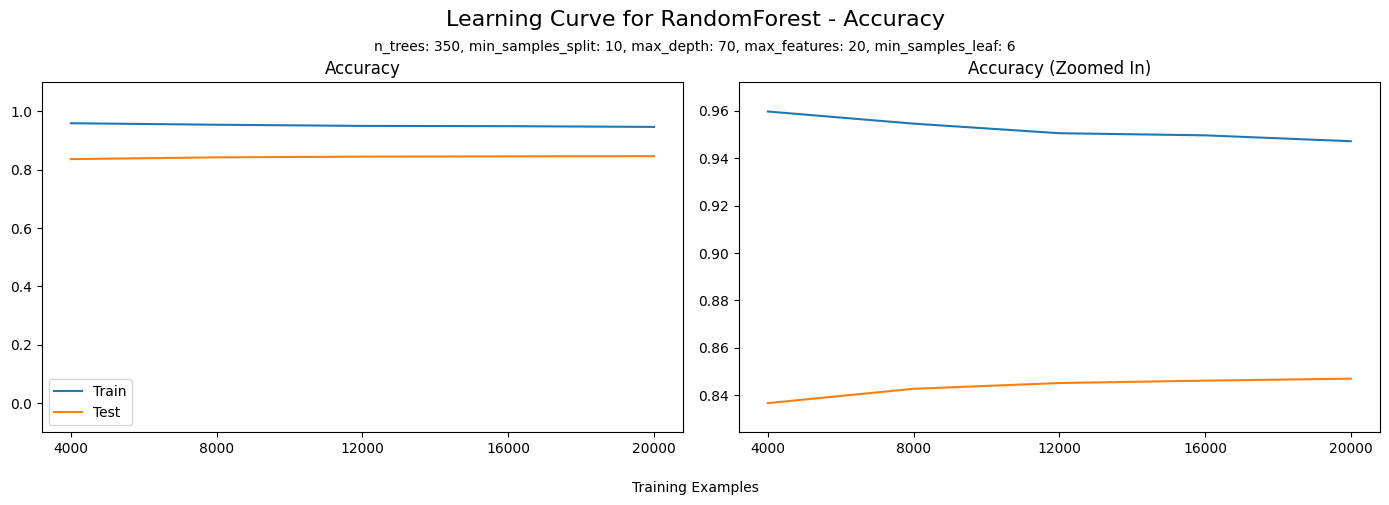

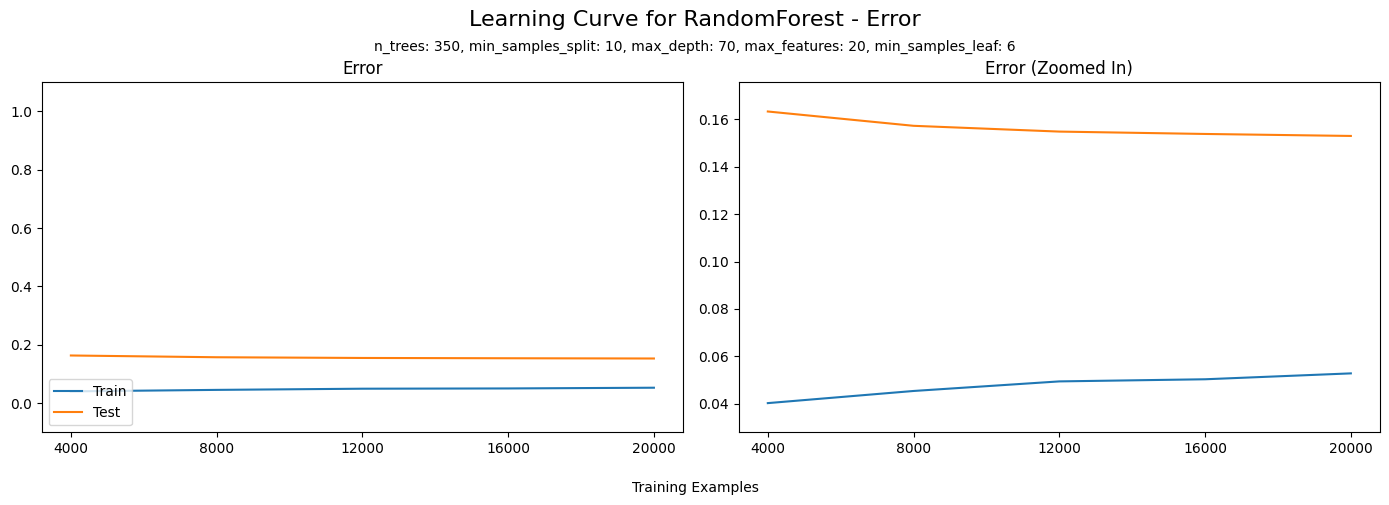

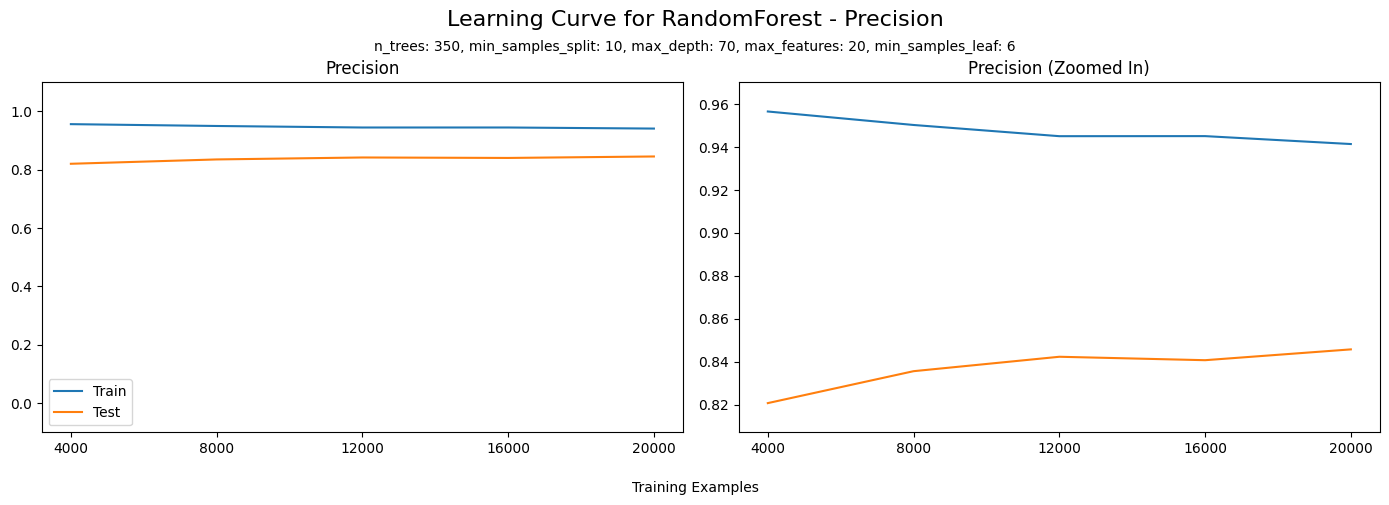

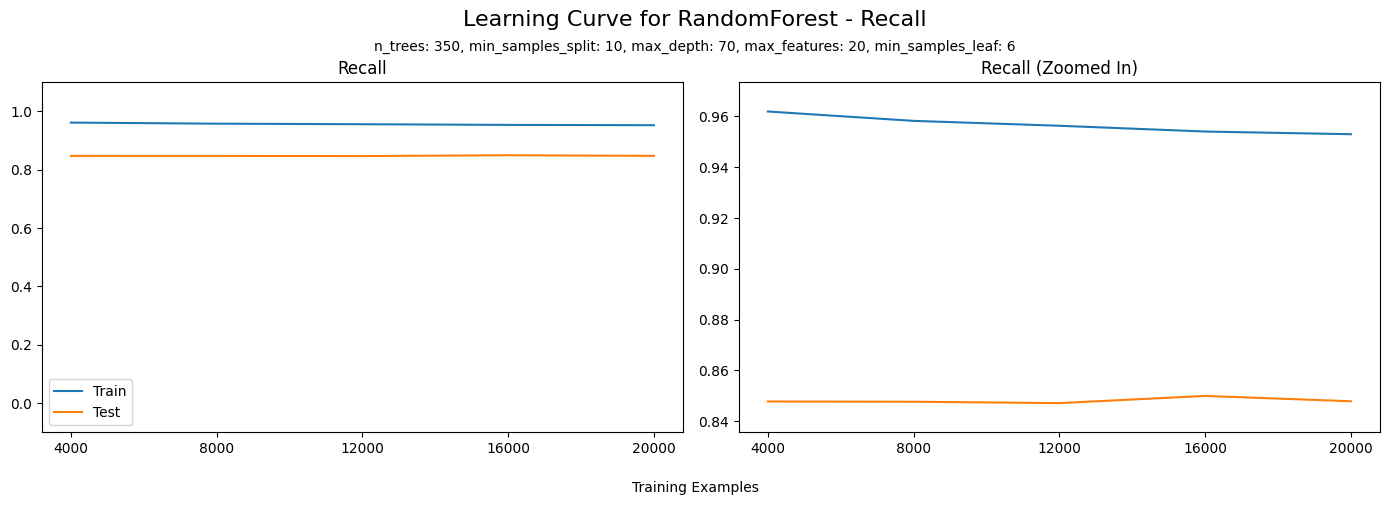

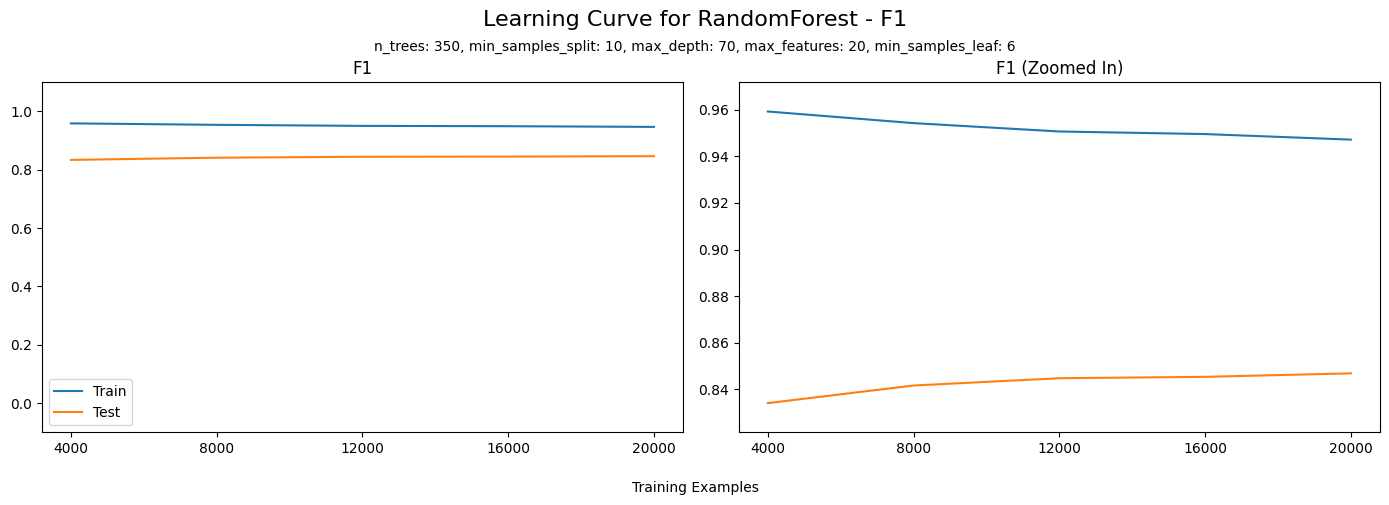

In [34]:
plot_learning_curves(random_forest, classification_data, label='My')

### Plot HeatMaps for the Classified Data

<Axes: title={'center': 'Confusion Matrix Heatmap for Train Data (used 2916 features)'}>

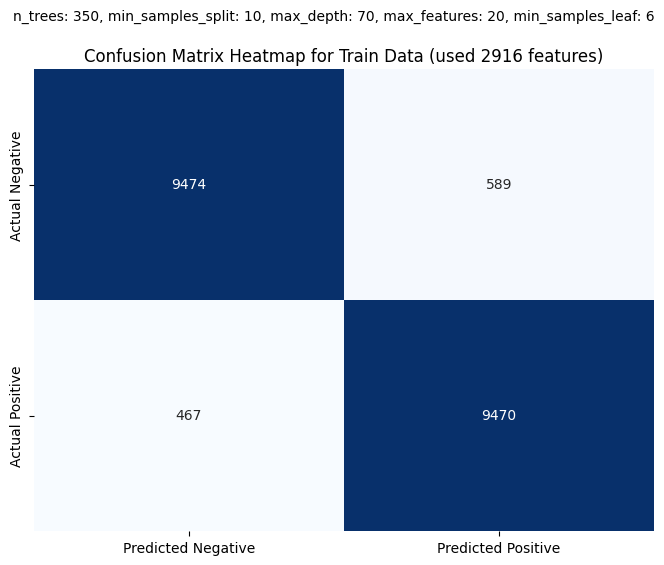

In [35]:
classification_cm_heatmap(random_forest, classification_data['train_final_cm'], 'Train Data (used ' + str(X_train_vectorized.shape[1]) + ' features)', label='My')

<Axes: title={'center': 'Confusion Matrix Heatmap for Test Data (used 2916 features)'}>

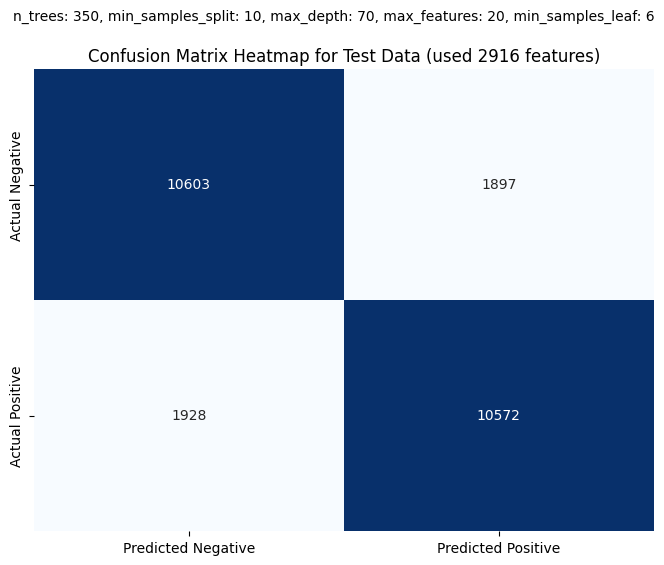

In [36]:
classification_cm_heatmap(random_forest, classification_data['test_final_cm'], 'Test Data (used ' + str(X_train_vectorized.shape[1]) + ' features)', label='My')

### Plot the ROC Curve for My Random Forest

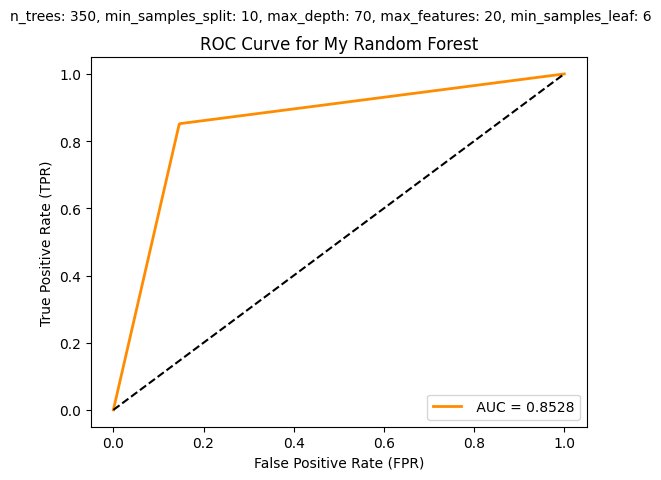

In [37]:
plot_ROC_curve(random_forest, X_test_vectorized, y_test, label='My')

### Initialize the built in Random Forest of scikit-learn

In [38]:
random_forest_model = RandomForestClassifier(criterion='entropy', n_estimators=max_trees, max_depth=max_depth, min_samples_leaf= minimum_samples_leaf ,min_samples_split=minimum_samples_split, max_features=max_features, bootstrap=True, random_state=42)

### Fine Tuning the hyperparameter of the built in model

In [29]:
param_distributions_SKL={
'n_estimators': [100, 150, 200, 250, 300, 350, 400],
'max_depth': [10, 20, 30, 40, 50, 60, 70],
'min_samples_split': [6, 8, 12, 16, 20],
'min_samples_leaf': [2, 4, 6, 8, 10],
'max_features': [10, 20, 30, 40, 50]}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_SKL, n_iter=50, n_jobs=6, label='Sklearn')

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Best parameters: {'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 10, 'max_depth': 70}
Best Accuracy score: 0.853


({'n_estimators': 250,
  'min_samples_split': 6,
  'min_samples_leaf': 10,
  'max_features': 10,
  'max_depth': 70},
 0.853)

In [44]:
param_distributions_SKL={
'n_estimators': [100, 150, 200, 250, 300, 350, 400],
'max_depth': [10, 20, 30, 40, 50, 60, 70],
'min_samples_split': [6, 8, 12, 16, 20],
'min_samples_leaf': [2, 4, 6, 8, 10],
'max_features': [10, 20, 30, 40, 50]}
randomized_search(X_train, y_train, X_val, y_val, param_distributions_SKL, n_iter=100, n_jobs=6, label='Sklearn')

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 60}
Best Accuracy score: 0.8534


({'n_estimators': 300,
  'min_samples_split': 6,
  'min_samples_leaf': 2,
  'max_features': 10,
  'max_depth': 60},
 0.8534)

In [93]:
param_distributions_SKL={
'n_estimators': [100, 150, 200, 250, 300, 350, 400],
'max_depth': [50, 60, 70, 80, 90, 100],
'min_samples_split': [8, 12, 16, 20, 24, 30],
'min_samples_leaf': [4, 6, 8, 10],
'max_features': [10, 20, 30, 40]}
randomized_search(X_train_vectorized, y_train, param_distributions_SKL, n_iter=20, cv=2, n_jobs=6, label='Sklearn')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters: {'n_estimators': 400, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 20, 'max_depth': 60}
Best Accuracy score: 0.85292


({'n_estimators': 400,
  'min_samples_split': 16,
  'min_samples_leaf': 4,
  'max_features': 20,
  'max_depth': 60},
 0.85292)

In [ ]:
param_distributions_SKL={
'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500],
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'min_samples_split': [2, 5, 8, 10, 12, 16, 20],
'min_samples_leaf': [1, 2, 4, 6, 8, 10],
'max_features': [5, 10, 20, 30, 40, 50, 'sqrt', 'log2']}
randomized_search(X_train_vectorized, y_train, param_distributions_SKL, n_iter=50, cv=2, n_jobs=6, label='Sklearn')

In [135]:
param_distributions_SKL={
'n_estimators': [100, 150, 200, 250, 300, 350, 400],
'max_depth': [50, 60, 70, 80, 90, 100],
'min_samples_split': [6, 8, 12, 16, 20, 24, 30],
'min_samples_leaf': [3, 4, 6, 8, 10],
'max_features': [5, 10, 20, 30, 40]}
randomized_search(X_train_vectorized, y_train, param_distributions_SKL, n_iter=40, cv=5, n_jobs=6, label='Sklearn')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'n_estimators': 350, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 100}
Best Accuracy score: 0.8608799999999999


({'n_estimators': 350,
  'min_samples_split': 16,
  'min_samples_leaf': 3,
  'max_features': 10,
  'max_depth': 100},
 0.8608799999999999)

In [ ]:
param_distributions_SKL_other={
'n_estimators': [100, 150, 200, 250, 300],
'max_depth': [50, 60, 70, 80],
'min_samples_split': [6, 8, 12, 16, 20],
'min_samples_leaf': [3, 4, 6, 8, 10],
'max_features': [5, 10, 20, 30]}
randomized_search(X_train_vectorized, y_train, param_distributions_SKL_other, n_iter=20, cv=5, n_jobs=6, label='Sklearn')

### Evaluate the built in model

In [39]:
classification_data_other = evaluate_estimator(random_forest_model, X_train, y_train, X_test, y_test, splits=5)

In [40]:
print_classification_report(classification_data_other, y_train, label='Train')

Used  2916  Features.
Classification Report for Train Data:
              precision    recall  f1-score   support

           0     0.9408    0.9222    0.9314     10063
           1     0.9228    0.9412    0.9319      9937

    accuracy                         0.9316     20000
   macro avg     0.9318    0.9317    0.9316     20000
weighted avg     0.9318    0.9316    0.9316     20000

Accuracy: 0.9316
Error: 0.0684
Precision: 0.9228
Recall: 0.9412
F1-score: 0.9319

Confusion Matrix:
True Negatives: 9280
False Positives: 783
False Negatives: 584
True Positives: 9353


In [41]:
print_classification_report(classification_data_other, y_test, label='Test')

Used  2916  Features.
Classification Report for Test Data:
              precision    recall  f1-score   support

           0     0.8564    0.8442    0.8502     12500
           1     0.8463    0.8584    0.8523     12500

    accuracy                         0.8513     25000
   macro avg     0.8514    0.8513    0.8513     25000
weighted avg     0.8514    0.8513    0.8513     25000

Accuracy: 0.8513
Error: 0.1487
Precision: 0.8584
Recall: 0.8463
F1-score: 0.8523

Confusion Matrix:
True Negatives: 10552
False Positives: 1948
False Negatives: 1770
True Positives: 10730


In [42]:
plot_metrics_table(classification_data_other)

,Accuracy Train,Accuracy Test,Error Train,Error Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.9452,0.8434,0.0547,0.1566,0.9411,0.8434,0.9482,0.8434,0.9447,0.8434
8000,0.9372,0.8467,0.0627,0.1533,0.9278,0.8492,0.9466,0.8449,0.9371,0.8471
12000,0.9344,0.8504,0.0656,0.1496,0.9232,0.8596,0.9471,0.8441,0.9350,0.8518
16000,0.9338,0.8510,0.0663,0.1490,0.9240,0.8582,0.9442,0.8460,0.9340,0.8521
20000,0.9316,0.8513,0.0684,0.1487,0.9228,0.8584,0.9412,0.8463,0.9319,0.8523


### Plot the Learning Curves for the built in Random Forest

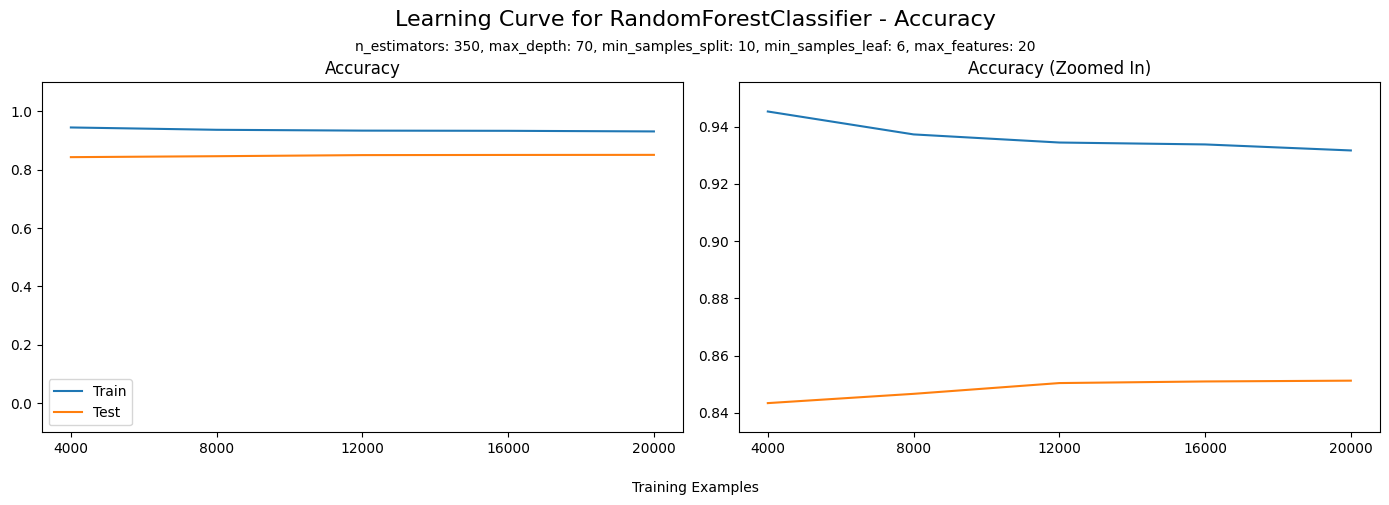

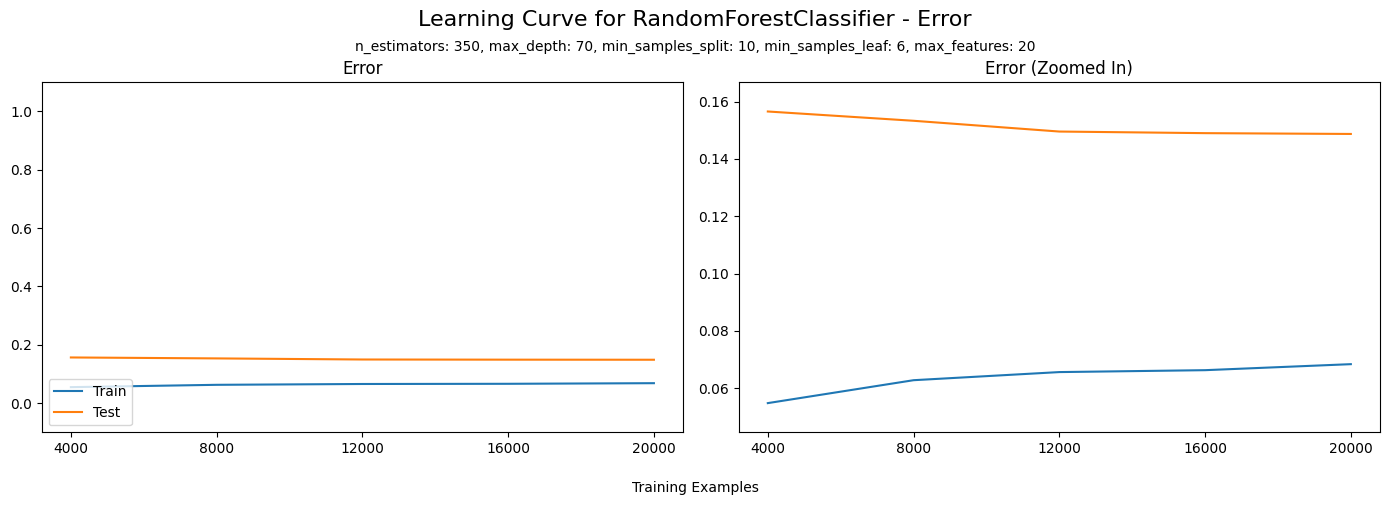

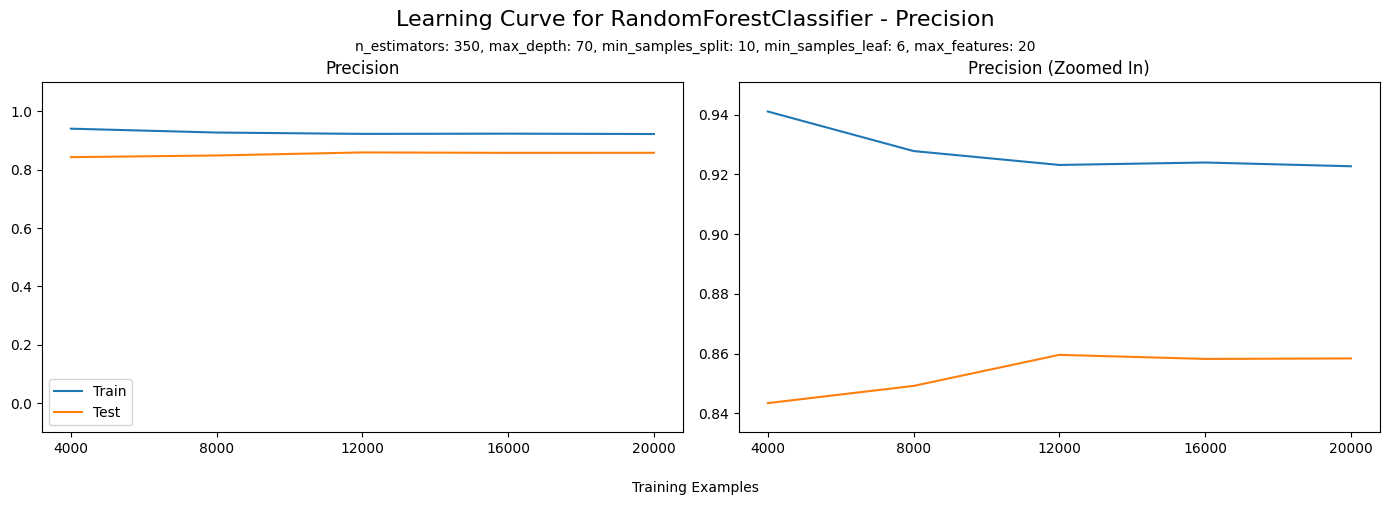

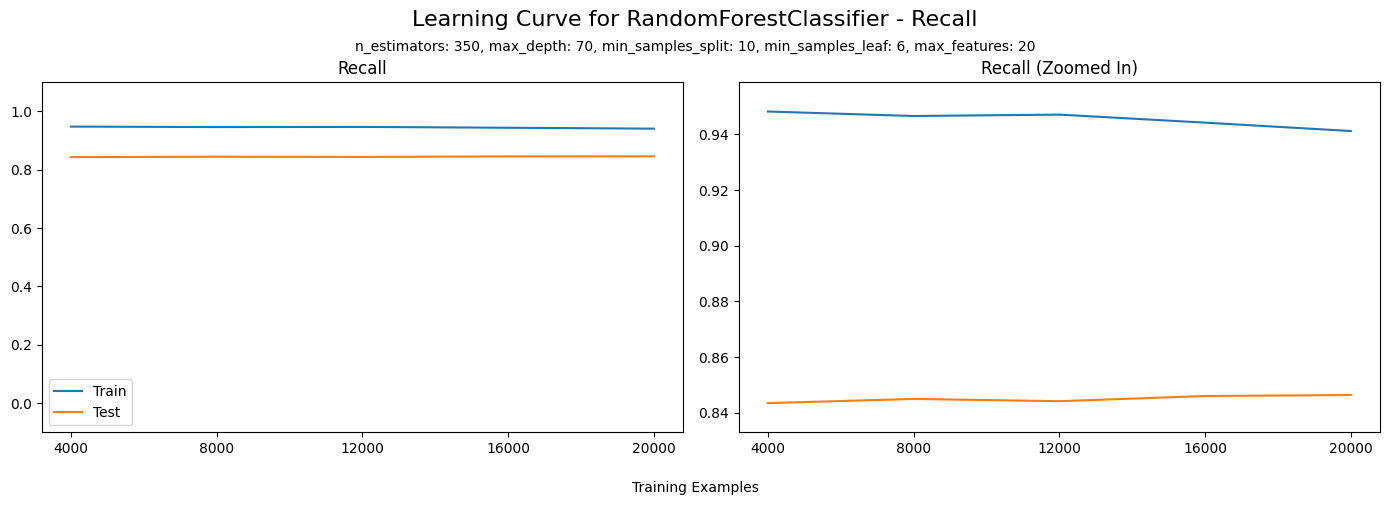

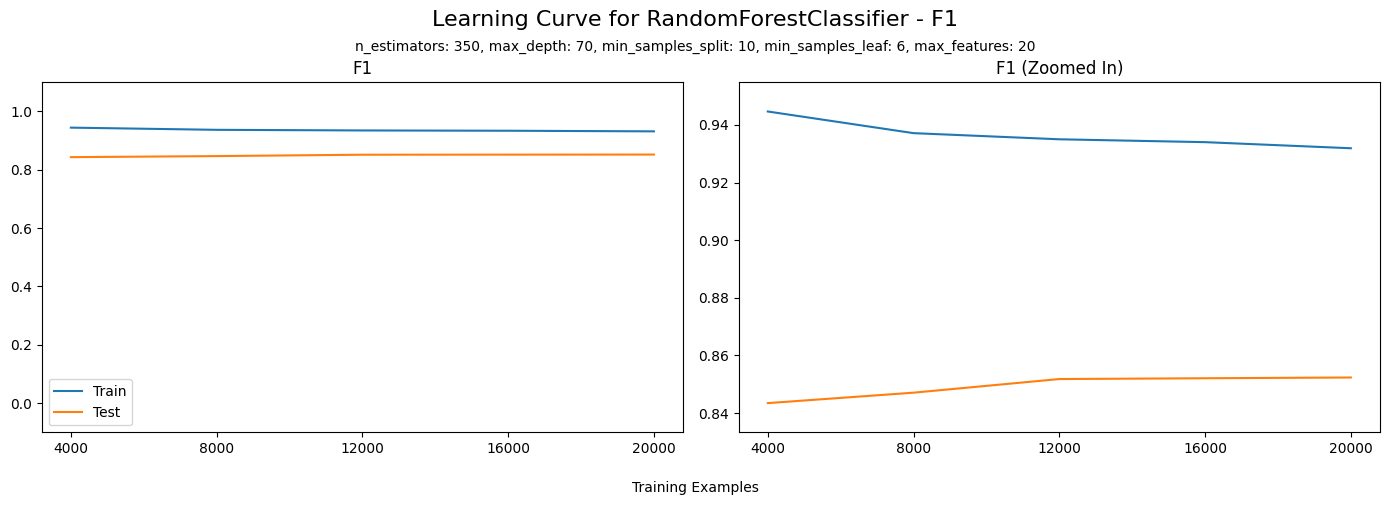

In [43]:
plot_learning_curves(random_forest_model, classification_data_other, label='Sklearn')

### Plot HeatMaps for the Classified Data

<Axes: title={'center': 'Confusion Matrix Heatmap for Train Data (used 2916 features)'}>

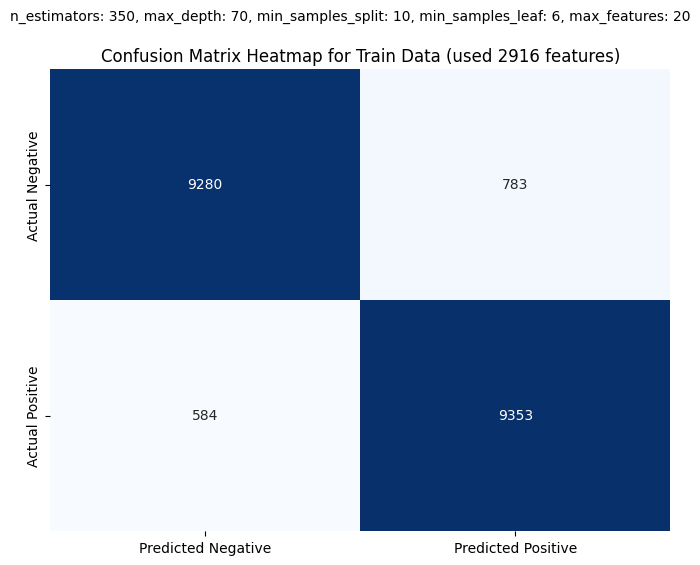

In [44]:
classification_cm_heatmap(random_forest_model, classification_data_other['train_final_cm'], 'Train Data (used ' + str(X_train_vectorized.shape[1]) + ' features)', label='Sklearn')

<Axes: title={'center': 'Confusion Matrix Heatmap for Test Data (used 2916 features)'}>

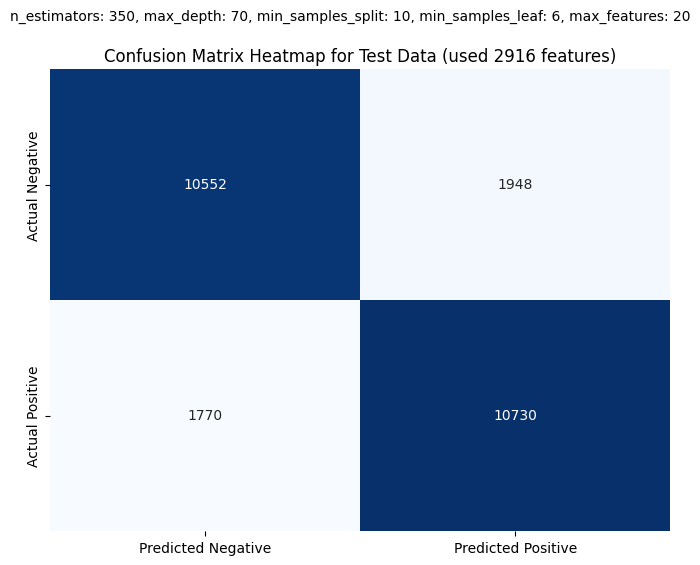

In [45]:
classification_cm_heatmap(random_forest_model, classification_data_other['test_final_cm'], 'Test Data (used ' + str(X_test_vectorized.shape[1]) + ' features)', label='Sklearn')

### Plot the ROC Curve for the built in Random Forest

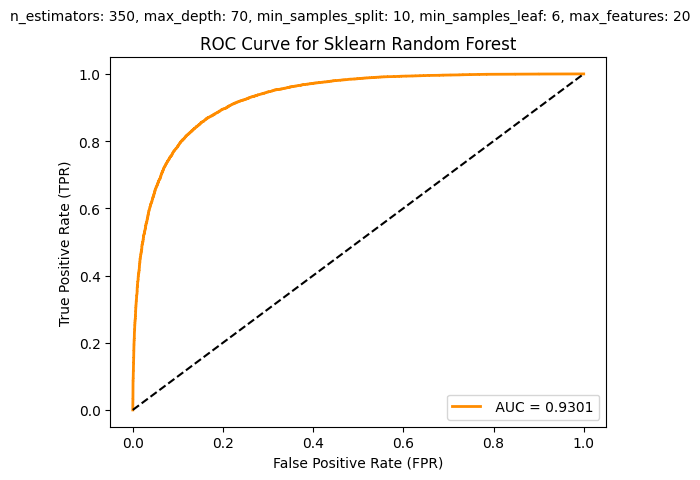

In [46]:
plot_ROC_curve(random_forest_model, X_test_vectorized, y_test, label='Sklearn')

### Random Forest against SciKitLearn's Random Forest

In [47]:
plot_metrics_table_differences(classification_data, classification_data_other)

,Accuracy Train,Accuracy Test,Error Train,Error Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.01,0.00,-0.01,0.00,0.02,-0.02,0.01,0.01,0.02,-0.01
8000,0.01,-0.01,-0.01,0.01,0.02,-0.01,0.01,0.01,0.01,-0.01
12000,0.02,0.00,-0.02,0.00,0.03,-0.02,0.01,0.01,0.01,-0.01
16000,0.02,0.00,-0.02,0.00,0.03,-0.02,0.01,0.00,0.02,0.00
20000,0.02,0.00,-0.02,0.00,0.02,-0.01,0.01,0.00,0.02,0.00


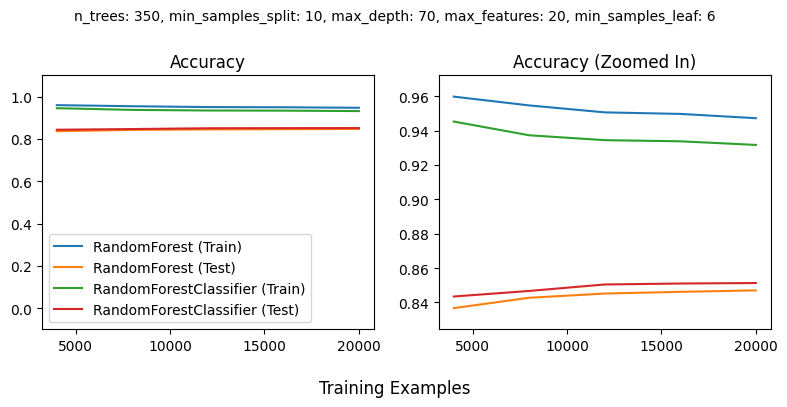

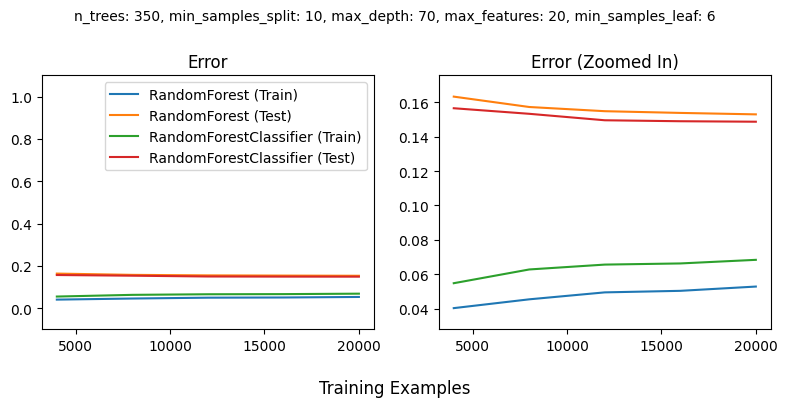

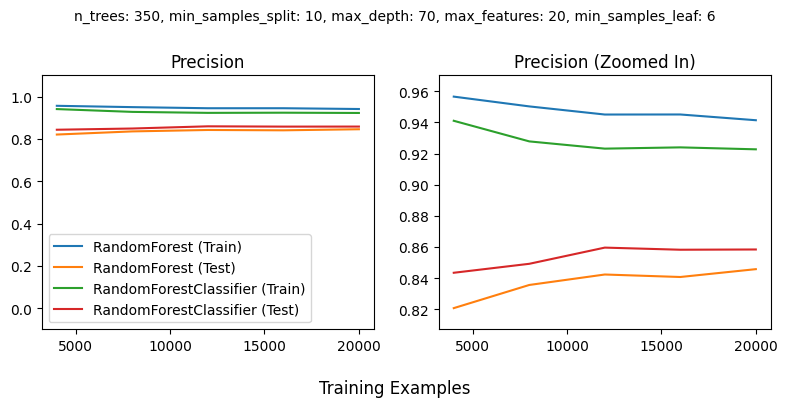

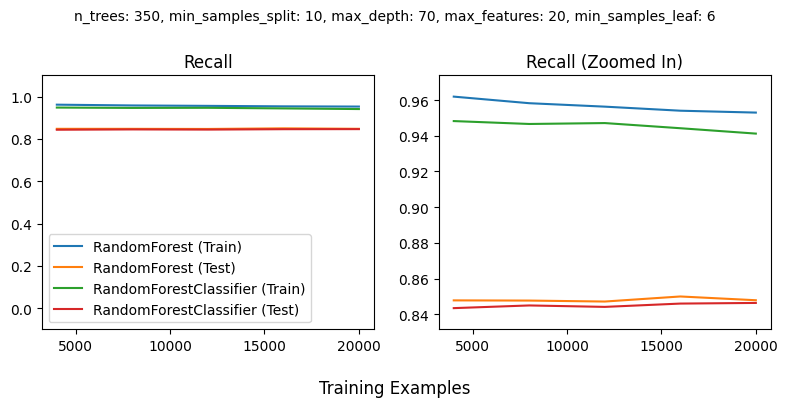

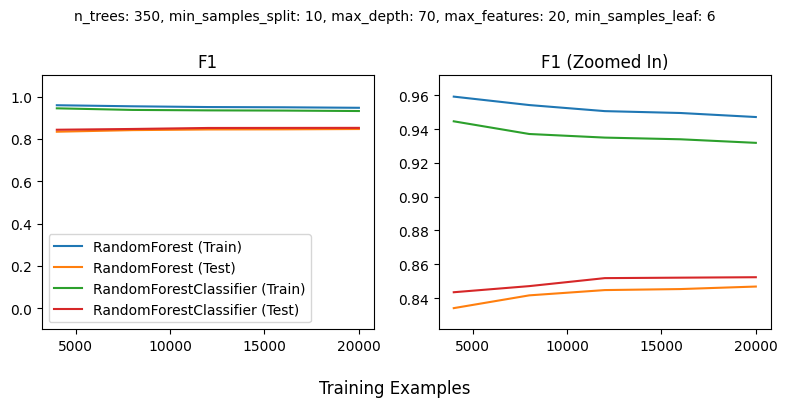

In [48]:
plot_classifier_differences(random_forest, classification_data, classification_data_other)

### Random Forest against SciKitLearn's Bernoulli Naive Bayes

In [49]:
from sklearn.naive_bayes import BernoulliNB

# Evaluate the scikit-learn's Bernoulli Naive Bayes
classification_data_NB = evaluate_estimator(BernoulliNB(), X_train, y_train, X_test, y_test, splits=5)

#### Compare metrics and plot differences

In [50]:
plot_metrics_table_differences(classification_data, classification_data_NB)

,Accuracy Train,Accuracy Test,Error Train,Error Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.08,0.01,-0.08,-0.01,0.07,0.01,0.09,0.00,0.08,0.00
8000,0.09,0.00,-0.09,0.00,0.09,0.01,0.10,0.00,0.09,0.00
12000,0.09,0.01,-0.09,-0.01,0.09,0.01,0.10,0.00,0.09,0.00
16000,0.09,0.01,-0.09,-0.01,0.10,0.00,0.09,0.01,0.09,0.01
20000,0.09,0.01,-0.09,-0.01,0.09,0.01,0.09,0.01,0.09,0.01


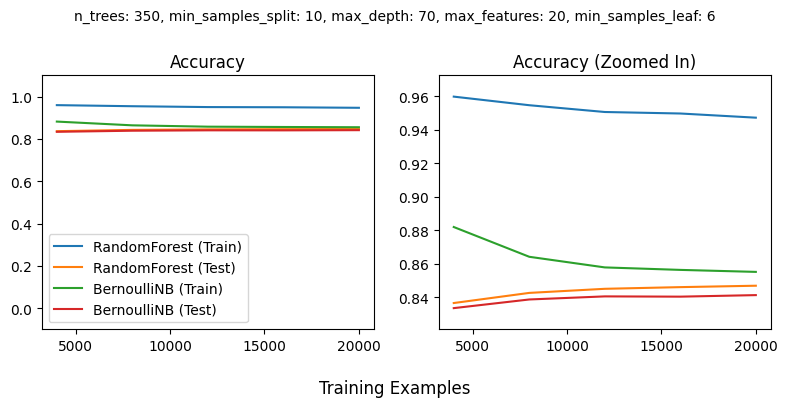

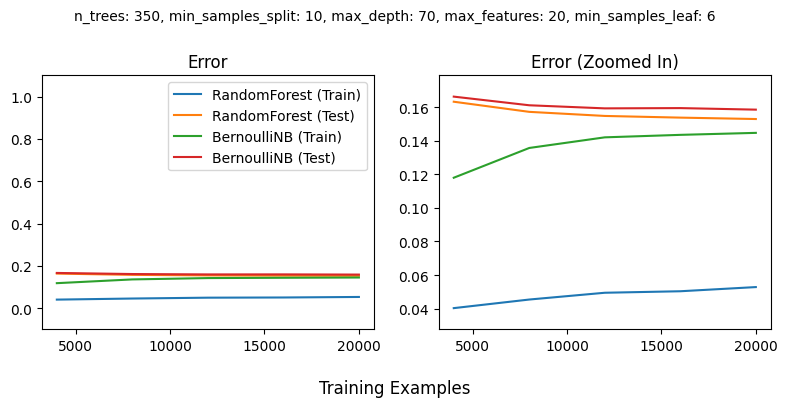

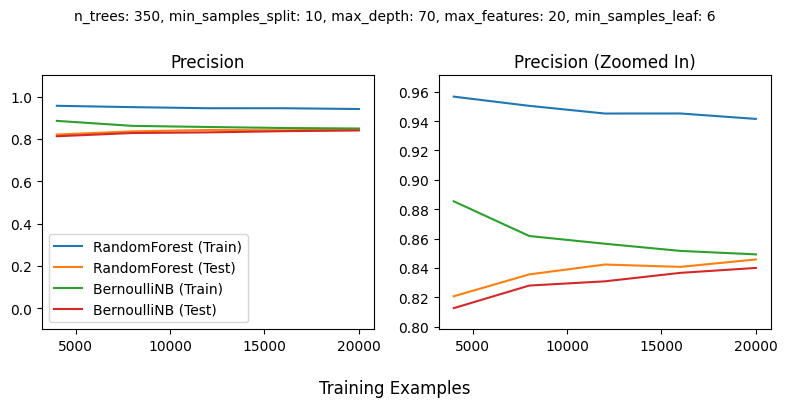

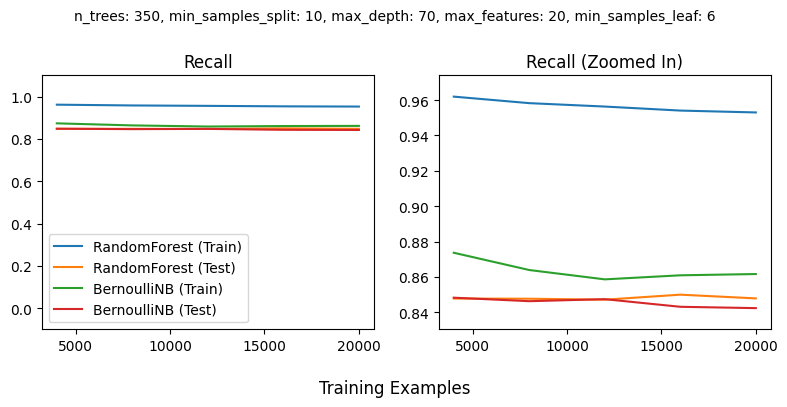

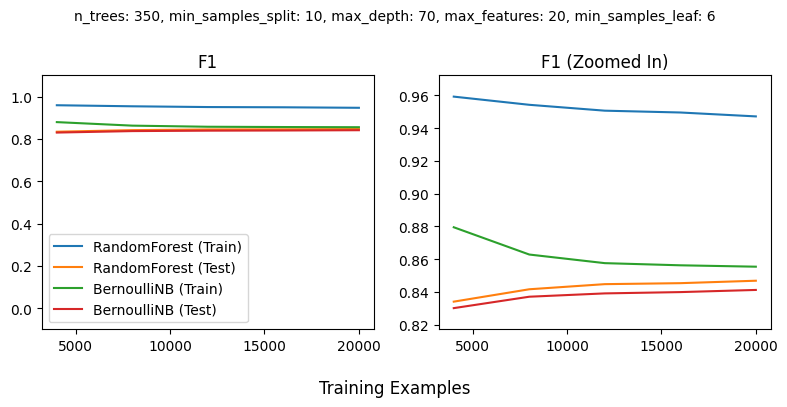

In [51]:
plot_classifier_differences(random_forest, classification_data, classification_data_NB)

### Random Forest against SciKitLearn's Logistic Regression

In [52]:
from sklearn.linear_model import SGDClassifier

# Evaluate the scikit-learn's SGDClassifier using log loss (logistic regression)
classification_data_LR = evaluate_estimator(SGDClassifier(loss='log_loss'), X_train, y_train, X_test, y_test, splits=5)

#### Compare metrics and plot differences

In [53]:
plot_metrics_table_differences(classification_data, classification_data_LR)

,Accuracy Train,Accuracy Test,Error Train,Error Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,-0.04,0.02,0.04,-0.02,-0.04,0.00,-0.04,0.03,-0.04,0.01
8000,-0.04,0.01,0.04,-0.01,-0.03,-0.01,-0.04,0.03,-0.04,0.01
12000,-0.01,0.01,0.01,-0.01,-0.01,-0.01,-0.01,0.02,-0.01,0.00
16000,0.01,0.00,-0.01,0.00,0.00,0.00,0.02,-0.01,0.01,0.00
20000,0.02,-0.01,-0.02,0.01,0.02,-0.03,0.00,0.00,0.02,-0.01


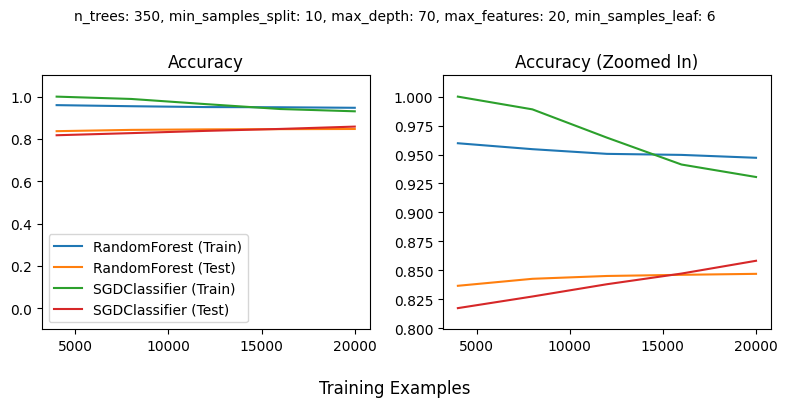

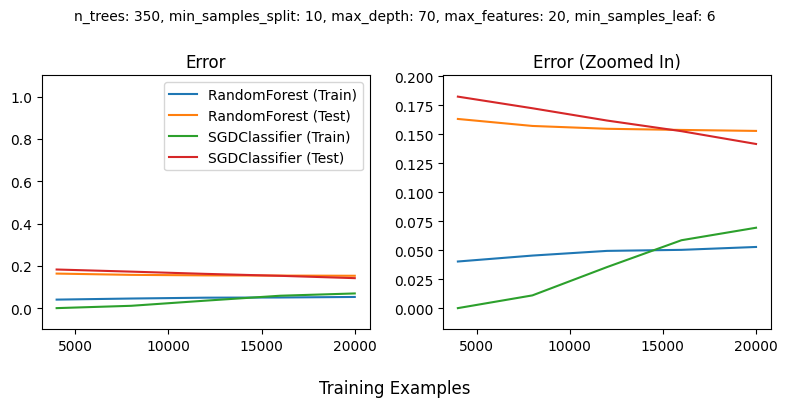

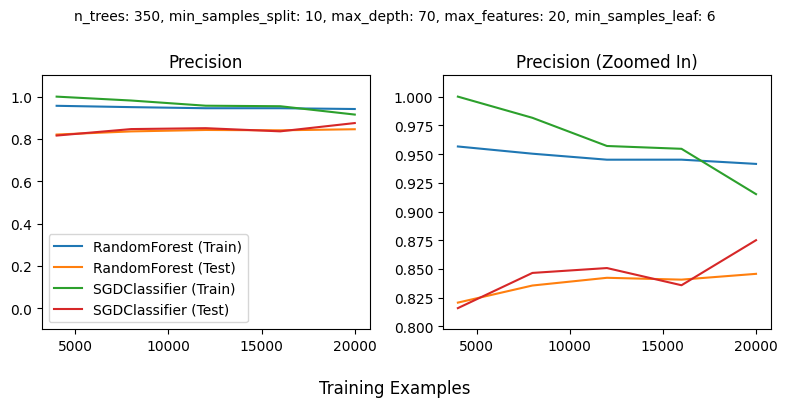

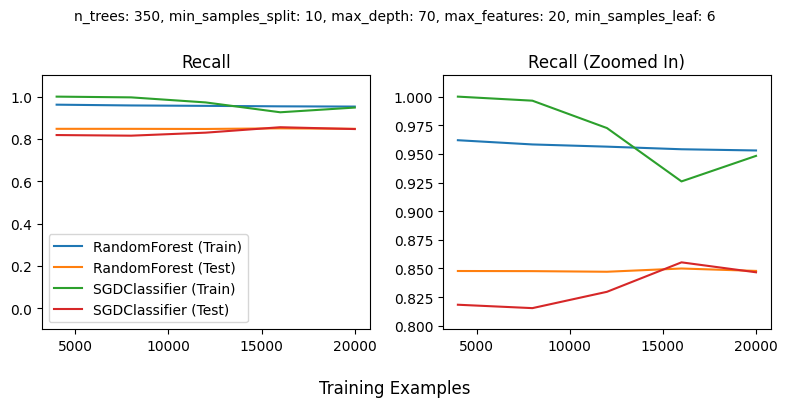

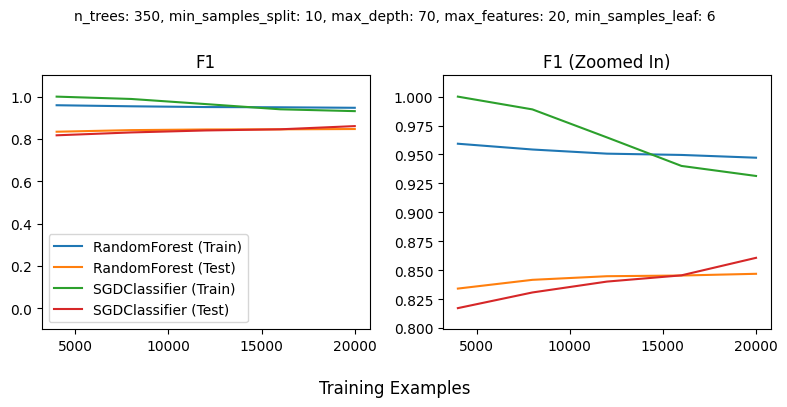

In [54]:
plot_classifier_differences(random_forest, classification_data, classification_data_LR)

### - Ada Boost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

# Evaluate the scikit-learn AdaBoost model
classification_dataAB = evaluate_estimator(AdaBoostClassifier(), X_train, y_train, X_test, y_test, splits=5)

#### Compare metrics and plot differences

In [56]:
plot_metrics_table_differences(classification_data, classification_dataAB)

,Accuracy Train,Accuracy Test,Error Train,Error Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4000,0.15,0.05,-0.15,-0.05,0.17,0.01,0.13,0.07,0.15,0.04
8000,0.15,0.04,-0.15,-0.04,0.17,0.02,0.13,0.07,0.15,0.04
12000,0.14,0.05,-0.14,-0.05,0.17,0.00,0.12,0.07,0.14,0.03
16000,0.14,0.05,-0.14,-0.05,0.16,0.00,0.11,0.07,0.14,0.04
20000,0.15,0.05,-0.15,-0.05,0.16,0.01,0.11,0.07,0.14,0.04


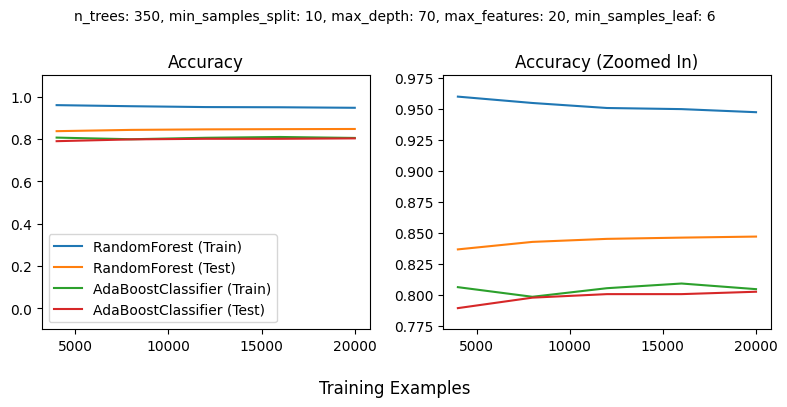

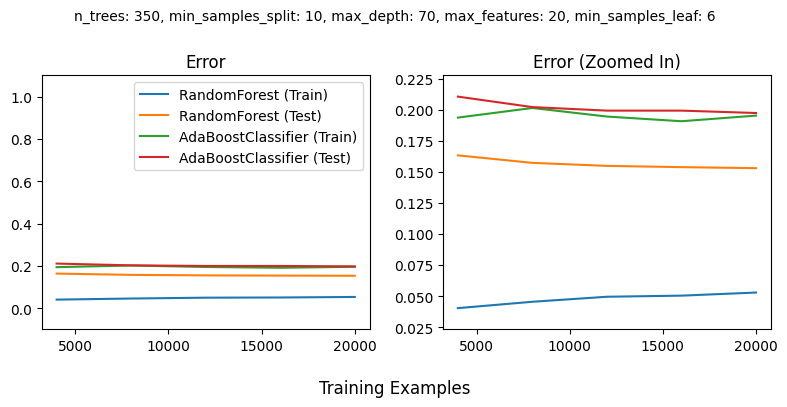

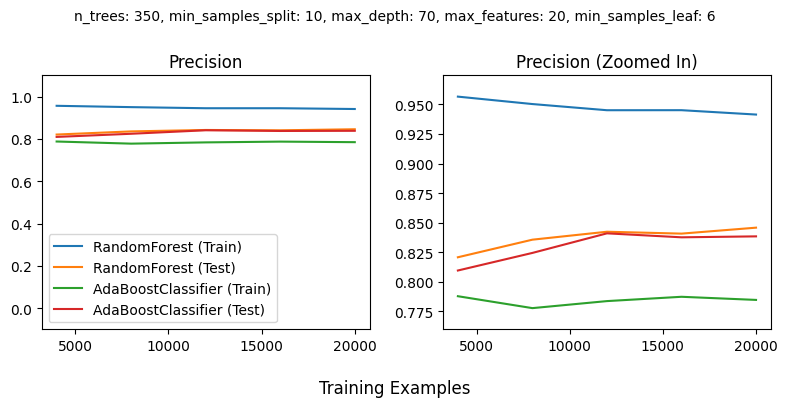

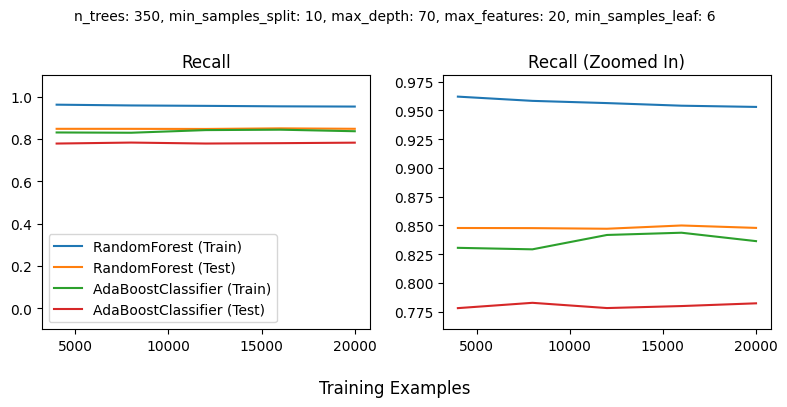

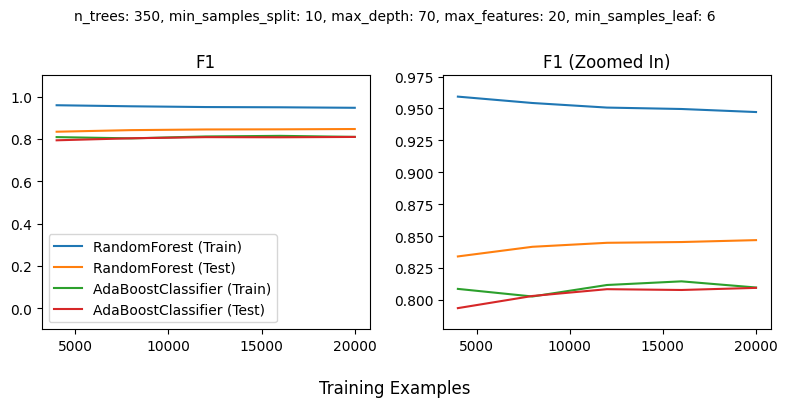

In [57]:
plot_classifier_differences(random_forest, classification_data, classification_dataAB)